In [2]:
import pandas as pd
import xarray as xr

dir_list_df = pd.read_csv('/user/ab5405/summeraliaclimate/code/dir_list.csv', index_col=0)
dir_list = dir_list_df['dir_path'].to_dict()


In [3]:
from funcs_support import get_filepaths

df_paths = get_filepaths(source_dir='proc', dir_list=dir_list)
df_paths.head()

,varname,freq,model,exp,run,gwl,proj_method,proj_base,dwnscl_method,dwnscl_target,suffix,filetype,path
0,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r22i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
1,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r1i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
2,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r2i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
3,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r11i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
4,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r25i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...


In [8]:
df_sub_new = df_paths.query("varname == 'tasdmgfparams' and gwl == 'ALLGWLs'").copy()

In [7]:
change_list = []
model_labels = []
run_labels = []

for i, row in df_sub_new.iterrows():
    ds = xr.open_zarr(row['path'])
    bin_mask_1 = ds['bin_f'] > 305.372
    bin_f_above90n = ds['bin_f'].where(bin_mask_1, drop =True)
    gwl_2 = ds['bins_behrer'].sel(gwl = 2.0, bin_f = bin_f_above90n, method = 'nearest')
    gwl_06 = ds['bins_behrer'].sel(gwl= 0.61, bin_f = bin_f_above90n, method = 'nearest')
    diff = gwl_2 - gwl_06
    
    change_list.append(diff)
    model_labels.append(row['model'])
    run_labels.append(row['run'])

In [9]:
diff_path = "/user/ab5405/summeraliaclimate/code/diff_90F_per_bin.nc"
diff.to_netcdf("/user/ab5405/summeraliaclimate/code/diff_90F_per_bin.nc")

In [10]:
import numpy as np
import pandas as pd

In [11]:
dmgf = xr.DataArray([0.69,0.59,0.64,0.36,0.27,0,0.12,0.23,0.33,0.94],dims=['bin'],coords=[np.arange(1,11)])
bins_dng = np.append(np.append(-np.inf,(np.arange(10,91,10)+459.67)*5/9),np.inf)
bin_name_dng = '_dng'

# This was total county income, Table 3. Wanted Table 2 instead
#dmgf_dnh = xr.DataArray([6.55,4.28,-1.73,-5.74,-10.61,-5.47,-3.12,-2.47,-1.07,-1.00,0,-2.77,-7.46,-6.92,-14.78,-16.71,-20.56],
#                          dims=['bin'],coords=[np.arange(1,18)])

# This is from table 2: "The effect of daily temperature on log total annual income per capita"
dmgf_dnh = xr.DataArray([0.000234,0.000126,-0.000144,-0.000269,-0.000322,-0.000195,-0.000119,-0.000074,-0.000003,-0.000036,
                         0,-0.000111,-0.000311,-0.000294,-0.000585,-0.000646,-0.000757],
                           dims=['bin'],coords=[np.arange(1,18)])
bins_dnh = np.append(np.append(-np.inf,np.arange(-15,31,3)+273.15),np.inf)
bin_name_dnh = '_dnh'

In [11]:
ds = xr.open_dataset(diff_path)
diff = ds['bins_behrer']
diff

<xarray.DataArray 'bins_behrer' (lat: 120, lon: 268, bin_f: 3)> Size: 772kB
[96480 values with dtype=float64]
Coordinates:
  * bin_f    (bin_f) float64 24B 306.8 309.5 312.3
  * lat      (lat) float64 960B 23.12 23.38 23.62 23.88 ... 52.38 52.62 52.88
  * lon      (lon) float64 2kB -126.9 -126.6 -126.4 ... -60.62 -60.38 -60.12

In [13]:
# Step 1: Load your delta days data
diff = xr.open_dataset(diff_path)['bins_behrer']  # shape: [bin_f, lat, lon]

# Step 2: Define the bin edges from dmgf_dnh
bin_edges_dnh = np.append(np.append(-np.inf, np.arange(-15, 31, 3) + 273.15), np.inf)

# Step 3: Use groupby_bins to rebin!
rebinned_diff = diff.groupby_bins('bin_f', bins=bin_edges_dnh, labels=np.arange(1, 18)).sum('bin_f')


In [14]:
# Make sure dmgf_dnh is loaded:
dmgf_dnh = xr.DataArray([0.000234,0.000126,-0.000144,-0.000269,-0.000322,-0.000195,-0.000119,-0.000074,-0.000003,-0.000036,
                         0,-0.000111,-0.000311,-0.000294,-0.000585,-0.000646,-0.000757], dims=['bin'], coords={'bin': np.arange(1, 18)})

# Multiply and sum
# Add lazy chunking — even if you didn't load from zarr
rebinned_diff = rebinned_diff.chunk({'lat': 30, 'lon': 30})
impact = rebinned_diff * dmgf_dnh
total_impact = impact.sum(dim='bin')

In [22]:
total_impact_small = total_impact[::2, ::2].compute()

In [23]:
print(total_impact_small.dims)

('lat', 'lon', 'bin_f_bins')


In [24]:
# Sum across bins, force compute
total_impact_2d = total_impact.sum(dim='bin_f_bins').compute()
total_impact_small = total_impact_2d[::2, ::2]  # downsample for plotting

print(total_impact_2d.dims)

('lat', 'lon')


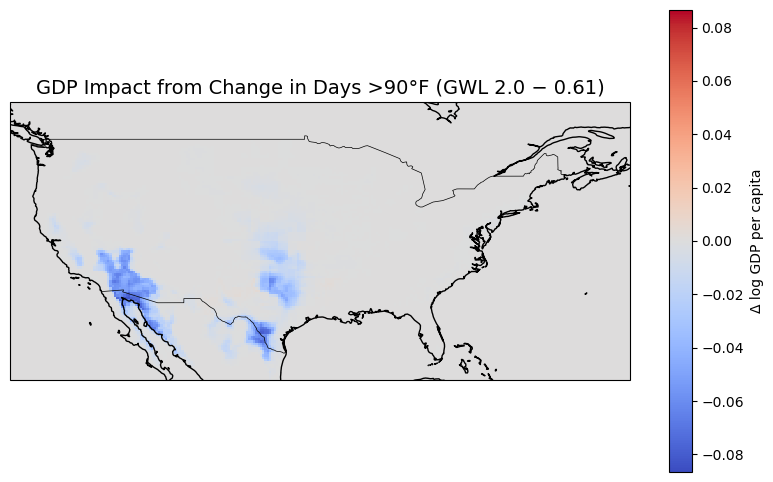

In [33]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

total_impact_2d.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='coolwarm',
    cbar_kwargs={'label': 'Δ log GDP per capita'}
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title("GDP Impact from Change in Days >90°F (GWL 2.0 − 0.61)", fontsize=14)
plt.show()


In [26]:
# Rebin using 10-bin mortality bins (already defined in `bins_dng`)
rebinned_diff_mort = diff.groupby_bins('bin_f', bins=bins_dng, labels=np.arange(1, 11)).sum('bin_f')


In [27]:
impact_mortality = rebinned_diff_mort * dmgf
total_impact_mortality = impact_mortality.sum(dim='bin')


In [30]:
total_impact_mortality_2d = total_impact_mortality.sum(dim='bin_f_bins').compute()
total_impact_m_small = total_impact_mortality_2d[::2, ::2]  # downsample for plotting


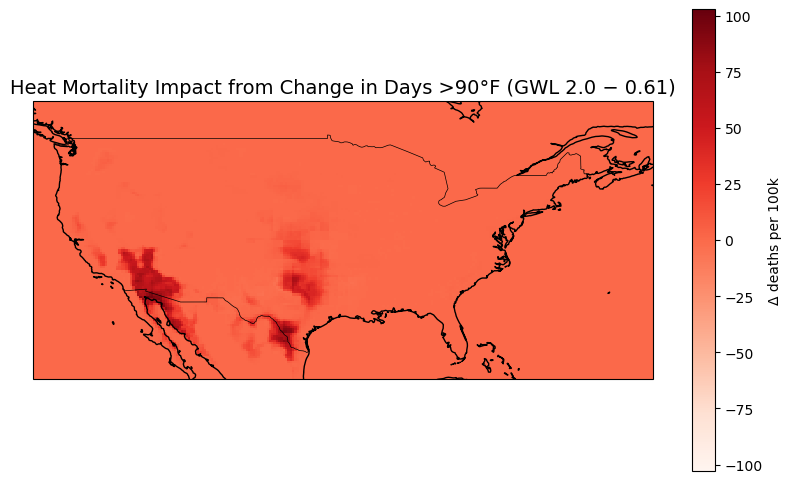

In [32]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

total_impact_mortality_2d.plot.pcolormesh(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap='Reds',
    cbar_kwargs={'label': 'Δ deaths per 100k'}
)

ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_title("Heat Mortality Impact from Change in Days >90°F (GWL 2.0 − 0.61)", fontsize=14)
plt.show()
